In [1]:

# 1. Data Preperation
# 2. Expected Sales Forecasting with BG-NBD Model
# 3. Expected Average Profit with Gamma-Gamma Model
# 4. Calculation CLTV with BG-NBD ve Gamma-Gamma Model
# 5. Building segmentation with CLTV

#  Data Preperation

##############################################################

In [2]:

#  Loading Necessary Library


In [1]:
# pip install lifetimes

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from sklearn.preprocessing import MinMaxScaler

In [2]:
def outlier_winsorize(df, col):
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df.loc[(df[col] < lower), col] = lower
    df.loc[(df[col] > upper), col] = upper

In [3]:

# Read Excel file


In [4]:
df_orj = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011",engine='openpyxl')
df = df_orj.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [5]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.1000,12680.0000,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.9500,12680.0000,France
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.0000,12680.0000,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.shape

(541910, 8)

In [8]:
# Data preprocessing

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [10]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

outlier_winsorize(df, "Quantity")
outlier_winsorize(df, "Price")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0000,11.8337,25.5345,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397925.0000,2.8932,3.2271,0.0000,1.2500,1.9500,3.7500,37.0600
Customer ID,397925.0000,15294.3086,1713.1727,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [11]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [12]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
today_date = dt.datetime(2011, 12, 11)

In [14]:

# Preparation of Lifetime Data Structure


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397925 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397925 non-null  object        
 1   StockCode    397925 non-null  object        
 2   Description  397925 non-null  object        
 3   Quantity     397925 non-null  float64       
 4   InvoiceDate  397925 non-null  datetime64[ns]
 5   Price        397925 non-null  float64       
 6   Customer ID  397925 non-null  float64       
 7   Country      397925 non-null  object        
 8   TotalPrice   397925 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 40.4+ MB


In [15]:
# recency: The elapsed time since the last purchase and first purchase. Weekly. (according to analysis day on cltv_df, user specific here)
# Tenure: The age of the customer. Weekly. (how long before the analysis date the first purchase was made)
# frequency: total number of repeat purchases (frequency>1)
# monetary_value: average earnings per purchase

cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
print(cltv_df.head(3))
print('*'*33)

cltv_df.columns = cltv_df.columns.droplevel(0)
print(cltv_df.head(3))
print('*'*33)

cltv_df.columns = ['recency', 'Tenure', 'frequency', 'monetary']

#average spending money on each purchase
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[cltv_df["monetary"] > 0]

# week conversion
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["Tenure"] = cltv_df["Tenure"] / 7

# frequency should be higher than 1
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
print(cltv_df.head(3))

            InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
*********************************
             <lambda_0>  <lambda_1>  <lambda>  <lambda>
Customer ID                                            
12346.0000            0         326         1  310.4400
12347.0000          365         368         7 4310.0000
12348.0000          282         359         4 1770.7800
*********************************
             recency  Tenure  frequency  monetary
Customer ID                                      
12347.0000   52.1429 52.5714          7  615.7143
12348.0000   40.2857 51.2857          4  442.6950
12352.0000   37.1429 42.4286          8  219.5425


In [16]:
cltv_df

,recency,Tenure,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100
...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967
18273.0000,36.4286,36.8571,3,68.0000
18282.0000,16.8571,18.1429,2,89.0250


In [21]:

#  BG-NBD Model Bulding


bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['Tenure'])


# 10 customers we expect the most to purchase in a week

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['Tenure'])

cltv_df["expected_purc_1_week"].sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2652
14911.0000   3.1266
17841.0000   1.9403
13089.0000   1.5375
14606.0000   1.4640
15311.0000   1.4337
12971.0000   1.3570
14646.0000   1.2225
13408.0000   0.9862
18102.0000   0.9686
Name: expected_purc_1_week, dtype: float64

In [22]:
cltv_df.head(10)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223
12359.0000,39.1429,47.4286,4,1371.8500,0.0995
12360.0000,21.1429,28.7143,3,878.5333,0.1196
12362.0000,41.7143,42.2857,10,522.6230,0.2240
12363.0000,18.8571,34.7143,2,276.0000,0.0756


In [23]:

# top 10 customer in 1 month = 4*week

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['Tenure'])
cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12748.0000,53.1429,53.4286,210,154.1924,3.2652,13.0257
14911.0000,53.1429,53.4286,201,691.7101,3.1266,12.4731
17841.0000,53.0000,53.4286,124,330.1344,1.9403,7.7403
13089.0000,52.2857,52.8571,97,606.3625,1.5375,6.1335
14606.0000,53.1429,53.4286,93,130.1390,1.4640,5.8403
15311.0000,53.2857,53.4286,91,667.7791,1.4337,5.7195
12971.0000,52.5714,53.2857,86,127.4859,1.3570,5.4135
14646.0000,50.4286,50.7143,74,3596.8044,1.2225,4.8764
13408.0000,53.0000,53.4286,62,453.5006,0.9862,3.9344


In [34]:
dfx = cltv_df['expected_purc_1_month']/cltv_df['expected_purc_1_week']

In [35]:
dfx.sort_values()

Customer ID
16000.0000   3.9429
17772.0000   3.9463
16479.0000   3.9463
17852.0000   3.9468
14893.0000   3.9468
              ...  
15311.0000   3.9893
14606.0000   3.9893
17841.0000   3.9893
14911.0000   3.9893
12748.0000   3.9893
Length: 2845, dtype: float64

In [24]:

# total expected purchase count of the company for 1 month

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['Tenure']).sum()

1777.145073163696

In [25]:

# total expected purchase count of the company for 3 month


bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['Tenure']).sum()

5271.849715637094

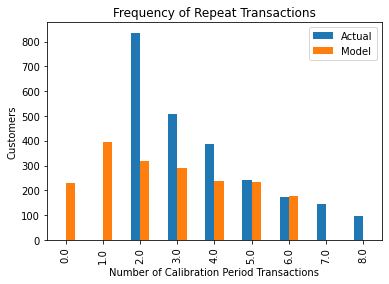

In [26]:

# Evaluation

#Plots a histogram and returns a matrix comparing the actual and expected number of customers 
#who made a certain number of repeat transactions in the calibration period, 
#binned according to calibration period frequencies.

plot_period_transactions(bgf)
plt.show();

In [27]:

# GAMMA-GAMMA Model

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5140,5772.1772
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0459,5029.4099
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,4288.9357
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,3918.8079
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0380,3917.1286
18102.0000,52.2857,52.5714,60,3859.7391,0.9686,3.8639,3870.9967
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,3678.5761
14646.0000,50.4286,50.7143,74,3596.8044,1.2225,4.8764,3605.3092
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,3216.0483


In [28]:

# BG-NBD ve GG model building the CLTV

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['Tenure'],
                                   cltv_df['monetary'],
                                   time=3,  #3 month
                                   freq="W",  # T unit.
                                   discount_rate=0.01)
cltv.head()

Customer ID
12347.0000   1128.4614
12348.0000    538.7980
12352.0000    517.5148
12356.0000   1083.0593
12358.0000    966.6801
Name: clv, dtype: float64

In [29]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(20)

,Customer ID,clv
1122,14646.0000,55722.4203
2761,18102.0000,47415.6701
843,14096.0000,29066.0386
36,12415.0000,27686.5223
1257,14911.0000,27379.3414
2458,17450.0000,27167.7406
874,14156.0000,23425.8613
2487,17511.0000,18987.6767
2075,16684.0000,13441.1749
650,13694.0000,12966.9410


In [30]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,74,3596.8044,1.2225,4.8764,3605.3092,55722.4203
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9686,3.8639,3870.9967,47415.6701
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7288,2.8960,3196.4354,29066.0386
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5140,5772.1772,27686.5223
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1266,12.4731,692.3264,27379.3414
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7475,2.9817,2874.1985,27167.7406
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8776,3.5007,2110.7541,23425.8613
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5089,2.0299,2950.5798,18987.6767
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9070,2223.8847,13441.1749
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8009,3.1948,1280.2182,12966.9410


In [31]:
# standardization of CLTV  for segmentation

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv
1122,14646.0000,50.4286,50.7143,74,3596.8044,1.2225,4.8764,3605.3092,55722.4203,1.0000
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9686,3.8639,3870.9967,47415.6701,0.8509
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7288,2.8960,3196.4354,29066.0386,0.5216
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5140,5772.1772,27686.5223,0.4969
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1266,12.4731,692.3264,27379.3414,0.4914
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7475,2.9817,2874.1985,27167.7406,0.4876
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8776,3.5007,2110.7541,23425.8613,0.4204
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5089,2.0299,2950.5798,18987.6767,0.3408
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9070,2223.8847,13441.1749,0.2412
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8009,3.1948,1280.2182,12966.9410,0.2327


In [32]:

# Segmentation 

cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,631.9120,1128.4614,0.0203,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,463.7455,538.7980,0.0097,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,224.8867,517.5148,0.0093,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,995.9977,1083.0593,0.0194,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,631.9010,966.6801,0.0173,A


In [33]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_average_profit                         clv                 scaled_clv             
                  sum       mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                  sum   mean count                   sum   mean count                     sum     mean count          sum      mean count        sum   mean count
segment                                                                                                                                                                                                                                                                                                     
D       11077046.0000 15557.6489   712 15715.5714 22.0724   712 28816.2857 40.4723   712      2184  3.0674   712 130948.6756 183.9167   712              50.6043 0.0711   712              201.5353 0.2831   712             141959.4892 199.3813   712  102009.4096  143.2716   712     1.8307 0.0026   712
C       10885739.0000 15310.4627   711 21807.1429 30.6711   711 27091.7143 38.1037   711      2911  4.0942   711 193165.2739 271.6811   711              85.7300 0.1206   711              341.3897 0.4802   711             206172.9514 289.9760   711  270726.9237  380.7692   711     4.8585 0.0068   711
B       10915854.0000 15352.8186   711 20985.0000 29.5148   711 24751.1429 34.8117   711      3869  5.4416   711 265517.6312 373.4425   711             115.5115 0.1625   711              459.7119 0.6466   711             280058.6456 393.8940   711  489367.4307  688.2805   711     8.7822 0.0124   711
A       10627572.0000 14947.3586   711 22333.1429 31.4109   711 24518.1429 34.4840   711      8078 11.3615   711 469109.4490 659.7883   711             194.5443 0.2736   711              774.5082 1.0893   711             487624.0925 685.8285   711 1580168.0736 2222.4586   711    28.3579 0.0399   711

# Thanks. !